# Test SINDy on Lorenz System with Control Inputs

This code demonstrates three methods to identify the governing equations of a non-linear dynamical system with a forced input.

The system used in these examples is the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) of ordinary differential equations.

Contents:
1. Generate data by simulating forced Lorenz system
2. Identify system dynamics using sparse regression
 1. Using SINDy recursive least-squares method
 2. Using L1-regularized feature selection in Scikit-Learn
 3. Using L1-regularized feature selection in Scikit-Learn with cross-validation

References:

1. Brunton, S. L., & Kutz, J. N. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (1st ed.). Cambridge University Press. http://www.databookuw.com

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, \
                                 MultiTaskLassoCV
from sklearn.feature_selection import SelectFromModel

# Local modules
from lorenz_forced import lorenz_forced_odes, lorenz_forced_odes_vectorized, \
                          scatter_plot_3d
from sindy import polynomial_features, sparsify_dynamics_lstsq, \
                  polynomial_feature_labels

%matplotlib inline

## 1. Generate data by simulating forced Lorenz system

In [2]:
dt = 0.01
T = 50
t = np.arange(0, T + dt, dt)

In [3]:
# Lorenz system parameters
beta = 8 / 3
sigma = 10
rho = 28
n = 3

In [4]:
# Initial condition
x0 = (-8, 8, 27)

In [5]:
# Control input
u = 10*np.sin(t/5)
uf = interp1d(t, u, kind='previous')
u = u[:-1]
assert u.shape == (5000,)

# u is a function defined in this range
uf(t[0]), uf(t[-1])

(array(0.), array(-5.44021111))

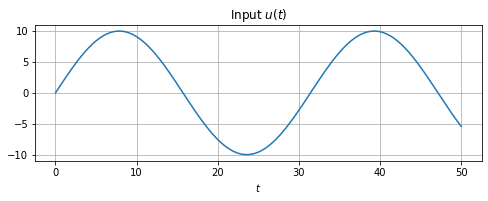

In [6]:
plt.figure(figsize=(8,2.5))
plt.plot(t, uf(t))
plt.title('Input $u(t)$')
plt.xlabel('$t$')
plt.grid()

In [7]:
%%time

# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab
fun = partial(lorenz_forced_odes, u=uf, sigma=sigma, beta=beta, rho=rho)
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
x = odeint(fun, x0, t[:-1], tfirst=True, rtol=rtol, atol=atol)
assert x.shape == (5000, 3)

CPU times: user 47.7 s, sys: 823 ms, total: 48.6 s
Wall time: 48.1 s


In [8]:
x[:5]

array([[-8.        ,  8.        , 27.        ],
       [-6.48640305,  7.80317052, 25.72552262],
       [-5.13782726,  7.56259206, 24.60881802],
       [-3.94095236,  7.31300704, 23.62896269],
       [-2.88097253,  7.07823176, 22.76580088]])

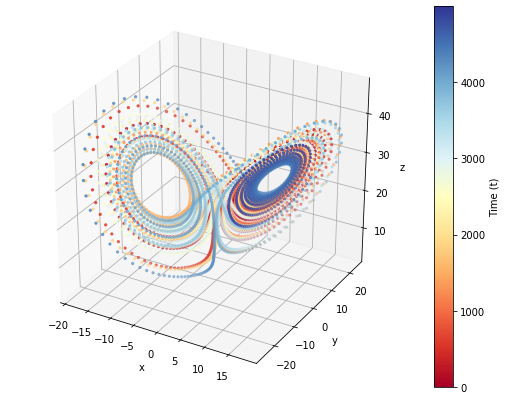

In [9]:
scatter_plot_3d(x)

In [10]:
# Calculate derivatives (vectorized version)
dx = lorenz_forced_odes_vectorized(t[:-1], x.T, uf, sigma, beta, rho).T
assert dx.shape == (5000, 3)

## 2. Identify system dynamics using sparse regression

### (i) Using SINDy recursive least-squares method

In [11]:
lamb = 0.025  # sparsification parameter lambda

In [12]:
x_u = np.hstack([x, u.reshape(-1,1)])
assert x_u.shape == (5000, 4)

In [13]:
poly_order = 2
theta = polynomial_features(x_u, order=poly_order)
assert theta.shape == (5000, 15), theta.shape

In [14]:
# Estimate sparse dynamic model
xi = sparsify_dynamics_lstsq(theta, dx, lamb, n)
assert xi.shape == (15, 3)

In [15]:
# Coefficients found by sparse regression
xi

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  1.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [16]:
# Display coefficients with labels
var_names = ['y1', 'y2', 'y3', 'u']
coef_labels = polynomial_feature_labels(x_u.shape[1], poly_order, 
                                        names=var_names)
assert len(coef_labels) == 15
pd.DataFrame(xi, columns=var_names[:3], index=coef_labels).round(3)

,y1,y2,y3
1,0.0,0.0,0.000
y1,-10.0,28.0,0.000
y2,10.0,-1.0,0.000
y3,0.0,0.0,-2.667
u,1.0,0.0,0.000
y1**2,0.0,0.0,0.000
y1*y2,0.0,0.0,1.000
y1*y3,0.0,-1.0,0.000
y1*u,0.0,0.0,0.000
y2**2,0.0,0.0,0.000


### B. Using L1-regularized feature selection in Scikit-Learn

See: https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection

In [17]:
poly_order = 2
poly = PolynomialFeatures(poly_order)
theta = poly.fit_transform(x_u)
assert theta.shape == (5000, 15), theta.shape
X, y = theta, dx
X.shape, y.shape

((5000, 15), (5000, 3))

In [18]:
# Set L1 penalty weight
alpha = 0.5

# Specify how many features to use
max_features = 8

# Find sparse model
estimator = Lasso(normalize=True, alpha=alpha)
selector = SelectFromModel(estimator, threshold=-np.inf, 
                           max_features=max_features)
selector.fit(X, y)

X_transform = selector.transform(X)
n_features = selector.transform(X).shape[1]
n_features

8

In [19]:
# Fit sparse model
estimator = LinearRegression()
estimator.fit(X_transform, y)
estimator.coef_.T.round(3)

array([[  0.   ,   0.   ,   0.   ],
       [-10.   ,  28.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ],
       [ -0.   ,   0.   ,  -2.667],
       [  1.   ,   0.   ,   0.   ],
       [  0.   ,  -0.   ,   1.   ],
       [  0.   ,  -1.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ]])

In [20]:
# Display coefficients with labels
selected_features = selector.get_support()
np.array(coef_labels)[selected_features]
pd.DataFrame(estimator.coef_.T, columns=var_names[:3], 
             index=np.array(coef_labels)[selected_features]).round(3)

,y1,y2,y3
1,0.0,0.0,0.000
y1,-10.0,28.0,-0.000
y2,10.0,-1.0,0.000
y3,-0.0,0.0,-2.667
u,1.0,0.0,0.000
y1*y2,0.0,-0.0,1.000
y1*y3,0.0,-1.0,-0.000
y2**2,0.0,0.0,0.000


### C. Using L1-regularized feature selection in Scikit-Learn with cross-validation

In [21]:
# Set L1 penalty
alpha = 0.5

# Specify how many features to use
max_features = 8

estimator = MultiTaskLassoCV(normalize=True, cv=5, alphas=[alpha]*4)

# Set minimum threshold
selector = SelectFromModel(estimator, threshold=-np.inf, 
                           max_features=max_features)
selector.fit(X, y)

X_transform = selector.transform(X)
n_features = selector.transform(X).shape[1]
n_features

8

In [22]:
estimator = LinearRegression()
estimator.fit(X_transform, y)
estimator.coef_.T.round(3)

array([[  0.   ,   0.   ,   0.   ],
       [-10.   ,  28.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ],
       [ -0.   ,   0.   ,  -2.667],
       [  1.   ,   0.   ,   0.   ],
       [  0.   ,  -0.   ,   1.   ],
       [  0.   ,  -1.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ]])

In [23]:
# Display coefficients with labels
selected_features = selector.get_support()
np.array(coef_labels)[selected_features]
pd.DataFrame(estimator.coef_.T, columns=var_names[:3], 
             index=np.array(coef_labels)[selected_features]).round(3)

,y1,y2,y3
1,0.0,0.0,0.000
y1,-10.0,28.0,-0.000
y2,10.0,-1.0,0.000
y3,-0.0,0.0,-2.667
u,1.0,0.0,0.000
y1*y2,0.0,-0.0,1.000
y1*y3,0.0,-1.0,-0.000
y2**2,0.0,0.0,0.000
